In [1]:
import numpy as np
import pandas as pd
import math

In [58]:
def LoadBFData(filename):
    data = pd.read_csv(filename, header=None, delimiter=" ")
    dataval = data.values
    if(dataval[0,0]==0.05):
        dataval=np.delete(dataval,0,0)
        print('deleting rapidity==0.05 row from',filename)
    dy = dataval[:,0]
    if(math.isnan(dataval[0,-1])):
        #print("last value (0,-1) in",filename,"is nan, removing last column")
        bf = dataval[:,1:-1]
    else:
        bf = dataval[:,1:]
    return dy, bf

def LoadBFDataAll(filenames):
    dy, BF = LoadBFData(filenames[0])
    for i in range(1,len(filenames)):
        dy, bf = LoadBFData(filenames[i])
        BF = np.concatenate((BF,bf),axis=0)
    return dy, BF

def LoadData(filename):
    datafile = pd.read_csv(filename, header=None, delimiter=" ")
    dataval = datafile.values
    if(math.isnan(dataval[0,-1])):
        #print("last value (0,-1) in",filename,"is nan, removing last column")
        dataval = dataval[:,:-1]
    return dataval

def normalize_features(X_train, X_test):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm

def NormFeatures(X_train__, X_test__,scale__):
    maxv__ = np.amax(X_train__,0)
    minv__ = np.amin(X_train__,0)
    X_train_norm__ = np.copy(X_train__)
    X_test_norm__ = np.copy(X_test__)
    for i in range(X_train_norm__.shape[1]):
        if(maxv__[i] != minv__[i]):
            X_train_norm__[:,i] = scale__*(X_train__[:,i]-minv__[i])/(maxv__[i]-minv__[i])
            X_test_norm__[:,i] = scale__*(X_test__[:,i]-minv__[i])/(maxv__[i]-minv__[i])
        else:
            X_train_norm__[:,i] = scale__*(X_train__[:,i]-minv__[i])
            X_test_norm__[:,i] = scale__*(X_test__[:,i]-minv__[i])
    return X_train_norm__, X_test_norm__, maxv__, minv__

def RestFeatures(X_train_norm__, X_test_norm__, maxv__, minv__,scale__):
    X_train__ = np.copy(X_train_norm__)
    X_test__ = np.copy(X_test_norm__)
    for i in range(X_train_norm__.shape[1]):
        if(maxv__[i] != minv__[i]):
            X_train__[:,i] = X_train_norm__[:,i]/scale__*(maxv__[i]-minv__[i])+minv__[i]
            X_test__[:,i] = X_test_norm__[:,i]/scale__*(maxv__[i]-minv__[i])+minv__[i]
        else:
            X_train__[:,i] = X_train_norm__[:,i]/scale__+minv__[i]
            X_test__[:,i] = X_test_norm__[:,i]/scale__+minv__[i]
    return X_train__, X_test__
    

In [98]:
folder="data"
pipi_modelname = folder+"/I211_J211.dat"
ppbar_modelname = folder+"/I2212_J2212.dat"
pk_modelname = folder+"/I321_J2212.dat"
kk_modelname = folder+"/I321_J321.dat"

model_filenames = [pipi_modelname,ppbar_modelname,pk_modelname,kk_modelname]
dy, model = LoadBFDataAll(model_filenames)
model = model.T
parameters = LoadData(folder+"/moments_parameters.dat")
moments = LoadData(folder+"/modelmoments.dat").T
pca = LoadData(folder+"/modelz.dat")

folder="data"
pipi_expname = folder+"/star_pipi.dat"
ppbar_expname = folder+"/star_ppbar.dat"
pk_expname = folder+"/star_pK.dat"
kk_expname = folder+"/star_KK.dat"
exp_filenames = [pipi_expname,ppbar_expname,pk_expname,kk_expname]
expdy, exp = LoadBFDataAll(exp_filenames)
expdy = np.delete(expdy,0,0)
exp = exp.T
exp = exp[0,:]
print(dy.shape,model.shape,expdy.shape,exp.shape,parameters.shape,moments.shape,pca.shape)

deleting rapidity==0.05 row from data/star_pipi.dat
deleting rapidity==0.05 row from data/star_ppbar.dat
deleting rapidity==0.05 row from data/star_pK.dat
deleting rapidity==0.05 row from data/star_KK.dat
(17,) (200, 68) (24,) (100,) (200, 12) (200, 12) (200, 12)


In [60]:
from random import *
import math

def LogLikeLihood(Y,y):
    return -0.5*np.sum((Y-y)*(Y-y))

class MCMC:
    def __init__(self,MLA__,X__,y__,target__,LLH__,step__,xmaxv__,xminv__):
        self.MLA__ = MLA__
        self.X__ = X__
        self.y__ = y__
        self.target__ = target__
        self.LLH__ = LLH__
        print("target:",self.target__)
        self.Z__ = np.zeros(2)
        self.Z__[0] = 1.5708
        self.Z__[1] = -1.04706 
        
        self.MLA__.fit(self.X__,self.y__)
        self.position__ = np.random.rand(self.X__.shape[1])
        self.positiony__ = self.MLA__.predict(self.position__.reshape(1,-1))
        self.llh__ = self.LLH__(self.target__,self.positiony__)
        self.maxLLH__ = self.llh__

        self.step_size__ = np.zeros(self.X__.shape[1]) + step__
        self.xmaxv__ = xmaxv__
        self.xminv__ = xminv__

    def step__(self):
        nmax__ = 1
        ab__ = 4
        testx__ = self.position__ + 2.0*(np.random.rand(len(self.position__)) - 0.5)*self.step_size__
        if(np.any(testx__ < 0) or np.any(testx__ > 1)):
            #print("out of range")
            return 0

        TestX__ = testx__*(self.xmaxv__ - self.xminv__) + self.xminv__
        for j__ in range(ab__):
            TestX__[j__*(nmax__+2)+1] = 1.0/TestX__[j__*(nmax__+2)]
            for k__ in range(1,nmax__+1):
                TestX__[j__*(nmax__+2)+1] -= TestX__[j__*(nmax__+2)+k__+1]*self.Z__[k__]
            TestX__[j__*(nmax__+2)+1] /= self.Z__[0]
        testx__ = (TestX__ - self.xminv__)/(self.xmaxv__ - self.xminv__)
        if(np.any(testx__ < 0) or np.any(testx__ > 1)):
            #print("out of range")
            return 0

        testy__ = self.MLA__.predict(testx__.reshape(1,-1))
        llh__ = self.LLH__(testy__,self.target__)
        if(llh__ > self.maxLLH__):
            self.maxLLH__ = llh__
            self.llh__ = llh__
            self.position__ = testx__
            self.positiony__ = testy__
            print("  MaxLLH:",self.maxLLH__)
            return 1
        if(llh__ > self.llh__):
            self.llh__ = llh__
            self.position__ = testx__
            self.positiony__ = testy__
            return 1
        else:
            rand__ = random()
            lnrand__ = math.log(rand__)
            if(lnrand__ > (llh__ - self.llh__)):
                return 0
            else:
                self.llh__ = llh__
                self.position__ = testx__
                self.positiony__ = testy__
                return 1
     
    def run__(self,count__):
        self.acct__ = 0
        self.trace__ = np.zeros((int(count__*4/25),self.X__.shape[1]))
        j__=0
        for i__ in range(count__):
            self.acct__ += self.step__()
            if((i__+1)%(count__/10)==0):
                print((i__+1)/count__*100,"% complete")
                print("  acct",self.acct__/(i__+1)*100,"%")
                print("  LLH",self.maxLLH__)
            if(i__>(count__/5) and i__%5==0):
                self.trace__[j__] = self.position__
                j__+=1


targetx: [0.24120579 0.24506449 0.53768845 1.         0.05640707 0.3819095
 0.68844211 0.1198805  0.552764   0.06532684 0.56458686 0.9798995 ]
target: [3.98612384 4.03273589 4.11923662 4.06471981 3.99117847 3.83902568
 3.6772896  3.54143019 3.28900709 3.18638393 3.03165864 2.94570136
 2.6984127  2.64760148 2.3853211  2.22222222 1.92307692 2.77606248
 2.99059788 3.49231754 3.51716247 2.93567894 2.60719755 2.42526519
 2.51351351 2.11466165 2.02453988 2.12053571 1.68478261 1.75925926
 1.13636364 1.         0.         0.         2.32739421 2.28530259
 2.78526149 3.28874025 3.47184987 3.40759076 2.83505155 2.70833333
 2.46938776 2.3125     1.88679245 2.16666667 2.30769231 2.22222222
 1.66666667 0.         0.         4.19004822 4.41966759 4.32078853
 3.88307552 3.32039911 2.80163599 2.44818653 1.98941799 1.80731364
 1.66023166 1.43243243 1.38497653 1.52542373 1.77777778 1.66666667
 0.         0.        ]
  MaxLLH: -46.13717146724865
  MaxLLH: -41.90882761604295
  MaxLLH: -32.14408483687965
 

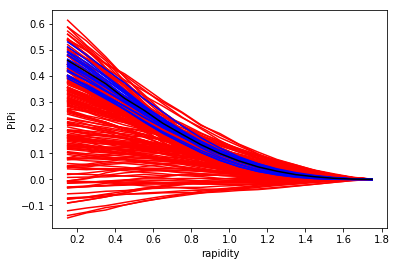

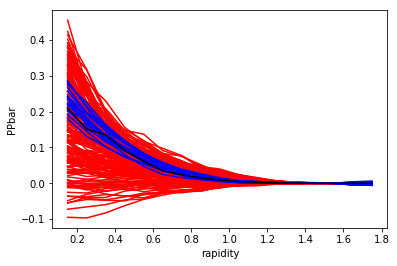

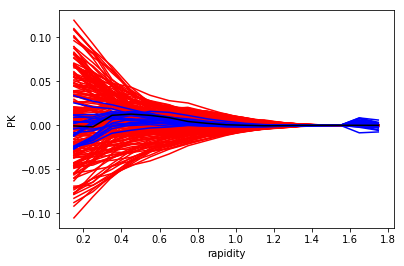

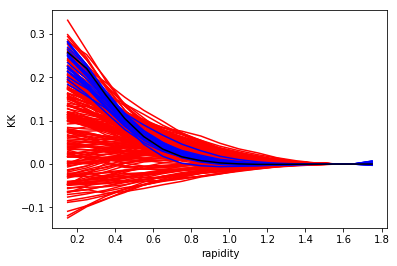

In [61]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
layer=100
X_train = parameters[:190,:]
y_train = model[:190,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

xscale=1.0
yscale=5.0
X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)
y_train_norm, y_test_norm, ymaxv, yminv = NormFeatures(y_train, y_test,yscale)
#y_train_buffed = y_train*scale

mla = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )


target=5
print("targetx:",X_train_norm[target])
step = 0.05
runs=1000000
mcmc = MCMC(mla,X_train_norm,y_train_norm,y_train_norm[target],LogLikeLihood,step,xmaxv,xminv)
mcmc.run__(runs)



xscale=1.0
yscale=5.0

ntrace = np.zeros((20,12))
for i in range(20):
    ntrace[i] = mcmc.trace__[int(mcmc.trace__.shape[0]/20*i),:]
print(ntrace)
x, posterior = RestFeatures(X_train_norm,ntrace,xmaxv,xminv,xscale)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  

tracey_buffed = mcmc.MLA__.predict(ntrace)
y_, tracey = RestFeatures(y_train_norm,tracey_buffed,ymaxv,yminv,yscale)

print("Red==200 Model Runs\nBlue==20 posterior from NN MCMC\nBlack==Target BF")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,tracey[:,:17].T,'blue')
plt.plot(dy,y_train[target,:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,tracey[:,17:34].T,'blue')
plt.plot(dy,y_train[target,17:34].T,'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,tracey[:,34:51].T,'blue')
plt.plot(dy,y_train[target,34:51].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,tracey[:,51:68].T,'blue')
plt.plot(dy,y_train[target,51:68].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")

In [63]:
x, posterior = RestFeatures(X_train_norm,ntrace,xmaxv,xminv,xscale)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  
numpy.savetxt('NNtrace.dat',mcmc.trace__,delimiter = ' ')

targetx: [0.24120579 0.24506449 0.53768845 1.         0.05640707 0.3819095
 0.68844211 0.1198805  0.552764   0.06532684 0.56458686 0.9798995 ]
target: [15.94449535 16.13094356 16.47694646 16.25887924 15.96471387 15.35610273
 14.70915842 14.16572077 13.15602837 12.74553571 12.12663455 11.78280543
 10.79365079 10.5904059   9.5412844   8.88888889  7.69230769 11.10424991
 11.96239151 13.96927017 14.06864989 11.74271578 10.4287902   9.70106075
 10.05405405  8.45864662  8.09815951  8.48214286  6.73913043  7.03703704
  4.54545455  4.          0.          0.          9.30957684  9.14121037
 11.14104596 13.15496098 13.88739946 13.63036304 11.34020619 10.83333333
  9.87755102  9.25        7.54716981  8.66666667  9.23076923  8.88888889
  6.66666667  0.          0.         16.7601929  17.67867036 17.28315412
 15.53230209 13.28159645 11.20654397  9.79274611  7.95767196  7.22925457
  6.64092664  5.72972973  5.5399061   6.10169492  7.11111111  6.66666667
  0.          0.        ]
  MaxLLH: -887.08143

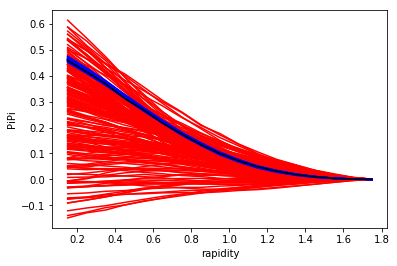

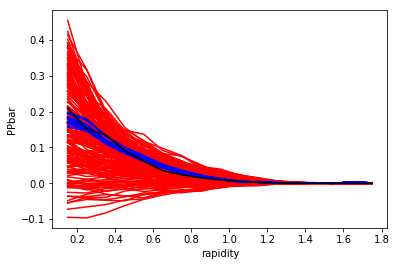

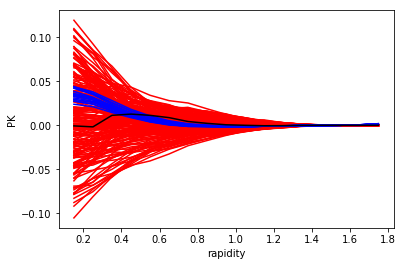

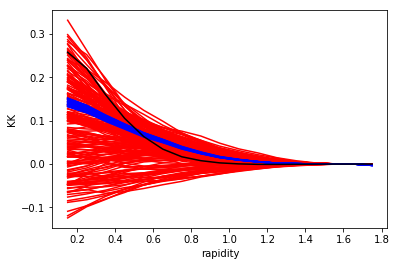

In [95]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
layer=100
X_train = parameters[:190,:]
y_train = model[:190,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

xscale=1.0
yscale=20.0
X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)
y_train_norm, y_test_norm, ymaxv, yminv = NormFeatures(y_train, y_test,yscale)
#y_train_buffed = y_train*scale

mla = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \
                  #random_sate=1, \
                 )


target=5
print("targetx:",X_train_norm[target])
step = 0.008
runs=1000000
mcmc = MCMC(mla,X_train_norm,y_train_norm,y_train_norm[target],LogLikeLihood,step,xmaxv,xminv)
mcmc.run__(runs)

ntrace = np.zeros((20,12))
for i in range(20):
    ntrace[i] = mcmc.trace__[int(mcmc.trace__.shape[0]/20*i),:]
print(ntrace)
x, posterior = RestFeatures(X_train_norm,ntrace,xmaxv,xminv,xscale)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  

tracey_buffed = mcmc.MLA__.predict(ntrace)
y_, tracey = RestFeatures(y_train_norm,tracey_buffed,ymaxv,yminv,yscale)

print("Red==200 Model Runs\nBlue==20 posterior from NN MCMC\nBlack==Target BF")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,tracey[:,:17].T,'blue')
plt.plot(dy,y_train[target,:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,tracey[:,17:34].T,'blue')
plt.plot(dy,y_train[target,17:34].T,'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,tracey[:,34:51].T,'blue')
plt.plot(dy,y_train[target,34:51].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,tracey[:,51:68].T,'blue')
plt.plot(dy,y_train[target,51:68].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")

In [67]:
x, posterior = RestFeatures(X_train_norm,ntrace,xmaxv,xminv,xscale)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  
numpy.savetxt('NNtrace.dat',mcmc.trace__,delimiter = ' ')

# EXPERIMENTAL TEST

In [49]:

expmod = np.append(exp[:17],exp[25:42])
expmod = np.append(expmod,exp[50:67])
expmod = np.append(expmod,exp[75:92])

In [87]:

expmod = np.append(exp[:17],exp[25:42])
expmod = np.append(expmod,exp[50:67])
expmod = np.append(expmod,exp[75:92])
expmod = expmod.reshape(1,-1)
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
layer=100
X_train = parameters[:200,:]
y_train = model[:200,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

xscale=1.0
yscale=20.0
X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)
y_train_norm, y_target_norm, ymaxv, yminv = NormFeatures(y_train, expmod,yscale)

mla = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )

step = 0.03
runs=1000000
mcmc = MCMC(mla,X_train_norm,y_train_norm,y_target_norm,LogLikeLihood,step,xmaxv,xminv)
mcmc.run__(runs)


ntrace = np.zeros((20,12))
for i in range(20):
    ntrace[i] = mcmc.trace__[int(mcmc.trace__.shape[0]/20*i),:]
print(ntrace)
tracey_buffed = mcmc.MLA__.predict(ntrace)
y_, tracey = RestFeatures(y_train_norm,tracey_buffed,ymaxv,yminv,yscale)

print("Red==200 Model Runs\nBlue==20 posterior from NN MCMC\nBlack==EXP BF")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,tracey[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,tracey[:,17:34].T,'blue')
plt.plot(dy,exp[25:42].T,'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,tracey[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,tracey[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")



target: [[ 1.24309726e+01  1.24729670e+01  1.22549907e+01  1.23487766e+01
   1.18283646e+01  1.15958168e+01  1.12504332e+01  1.08982217e+01
   1.06222518e+01  1.04229911e+01  1.01288369e+01  1.07198190e+01
   1.05426129e+01  9.89889299e+00  9.75290520e+00  1.15587302e+01
   2.03846154e+01  6.57671631e+00  9.02439730e+00  1.12469270e+01
   1.32057666e+01  1.28942276e+01  1.38549020e+01  1.44460945e+01
   1.53664865e+01  1.46112782e+01  1.48588957e+01  1.46830357e+01
   1.80152174e+01  1.60185185e+01  1.42000000e+01  7.20000000e+00
   2.20000000e-04  0.00000000e+00  1.16413363e+01  1.21606916e+01
   1.23947702e+01  1.31957637e+01  1.26581769e+01  1.22234323e+01
   1.04495902e+01  9.76445623e+00  1.07530303e+01  6.96785714e+00
   7.87889908e+00  1.02366667e+01  8.68461538e+00  1.75777778e+01
   2.14666667e+01 -4.40000000e-04 -0.00000000e+00  9.03954406e+00
   9.89324100e+00  1.08417921e+01  1.15470428e+01  1.20618625e+01
   1.21719155e+01  1.28537133e+01  1.19752381e+01  1.16967651e+01
  

KeyboardInterrupt: 

target: [[ 3.25801e-01  2.91725e-01  2.44409e-01  2.13718e-01  1.76366e-01
   1.45787e-01  1.18907e-01  9.10200e-02  7.14190e-02  5.04900e-02
   3.39860e-02  2.56270e-02  1.71720e-02  8.12600e-03  4.44600e-03
   2.68200e-03  8.25000e-04  8.59570e-02  9.03660e-02  9.29770e-02
   8.17730e-02  7.24730e-02  5.87580e-02  4.84030e-02  3.47560e-02
   2.55660e-02  1.60200e-02  9.64500e-03  6.08700e-03  2.82500e-03
   1.13300e-03  1.60000e-05  1.10000e-05  0.00000e+00  2.54740e-02
   2.43940e-02  1.92110e-02  1.28830e-02  6.71500e-03  4.43700e-03
   1.99700e-03 -5.94000e-04  7.94000e-04 -2.34700e-03 -5.06000e-04
   7.10000e-05 -1.71000e-04  3.91000e-04  2.22000e-04 -2.20000e-05
  -0.00000e+00  8.18920e-02  8.00730e-02  6.97430e-02  6.14020e-02
   5.23980e-02  4.15810e-02  3.45230e-02  2.67830e-02  1.85820e-02
   1.46670e-02  1.04820e-02  6.28100e-03  2.46500e-03  7.81000e-04
   2.27000e-04 -3.60000e-05 -3.00000e-06]]
  MaxLLH: -0.03821099741487869
  MaxLLH: -0.03248801251658269
  MaxLLH: -0.027

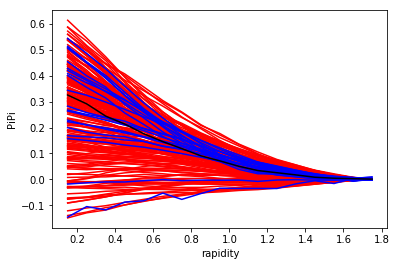

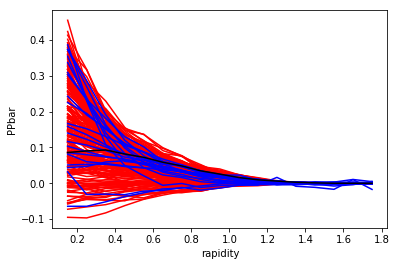

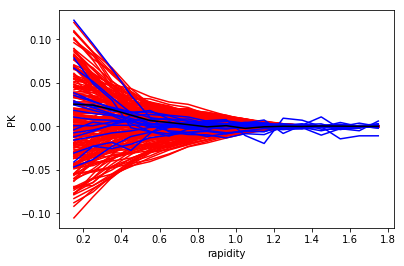

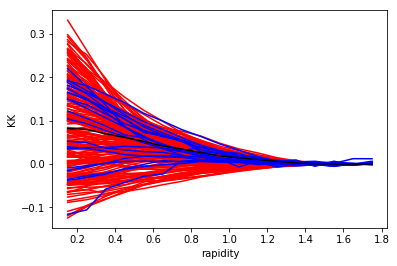

In [90]:

expmod = np.append(exp[:17],exp[25:42])
expmod = np.append(expmod,exp[50:67])
expmod = np.append(expmod,exp[75:92])
expmod = expmod.reshape(1,-1)
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
layer=100
X_train = parameters[:200,:]
y_train = model[:200,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

xscale=1.0
yscale=1.0
X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)
y_train_norm = y_train
y_target_norm = expmod
#y_train_norm, y_target_norm, ymaxv, yminv = NormFeatures(y_train, expmod,yscale)

mla = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )

step = 0.08
runs=1000000
mcmc = MCMC(mla,X_train_norm,y_train_norm,y_target_norm,LogLikeLihood,step,xmaxv,xminv)
mcmc.run__(runs)


ntrace = np.zeros((20,12))
for i in range(20):
    ntrace[i] = mcmc.trace__[int(mcmc.trace__.shape[0]/20*i),:]
print(ntrace)
tracey_buffed = mcmc.MLA__.predict(ntrace)
tracey = tracey_buffed
#y_, tracey = RestFeatures(y_train_norm,tracey_buffed,ymaxv,yminv,yscale)

print("Red==200 Model Runs\nBlue==20 posterior from NN MCMC\nBlack==EXP BF")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,tracey[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,tracey[:,17:34].T,'blue')
plt.plot(dy,exp[25:42].T,'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,tracey[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,tracey[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")


In [93]:
x, posterior = RestFeatures(X_train_norm,ntrace,xmaxv,xminv,xscale)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  
numpy.savetxt('NNtrace.dat',mcmc.trace__,delimiter = ' ')

[[0.48047047 0.17022854 0.58058104 0.62278032 0.09021013 0.4192175
  0.93758444 0.08087049 0.43723754 0.39189719 0.11583731 0.29513661]
 [0.57146404 0.15288298 0.56953005 0.94672318 0.07527146 0.46278859
  0.54932162 0.07360185 0.23610122 0.63986662 0.13144085 0.57582686]
 [0.45032646 0.16953795 0.54914881 0.74629058 0.11823374 0.62128462
  0.77883334 0.10148006 0.49489305 0.32290165 0.104049   0.13215271]
 [0.42121021 0.16685726 0.50611238 0.89018294 0.10569046 0.60460136
  0.61758032 0.08575656 0.34120765 0.81361239 0.12229581 0.60276785]
 [0.3415315  0.17983797 0.45860236 0.4313254  0.1038956  0.34259468
  0.64937904 0.09764455 0.41940367 0.7435267  0.1364505  0.64819956]
 [0.35726619 0.17826529 0.47584475 0.99923714 0.11023728 0.6556904
  0.48503702 0.07190627 0.17745088 0.6207468  0.13855259 0.60118051]
 [0.39875273 0.17517716 0.5179942  0.72532065 0.1051609  0.54537797
  0.67202334 0.09177625 0.40037594 0.78082452 0.13751576 0.6676677 ]
 [0.63070829 0.17038398 0.68494789 0.471367

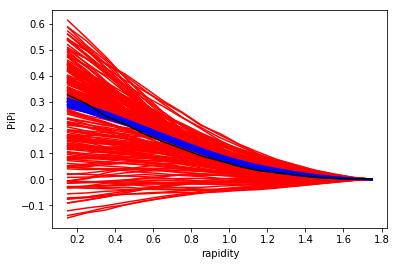

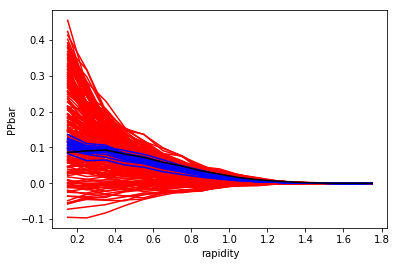

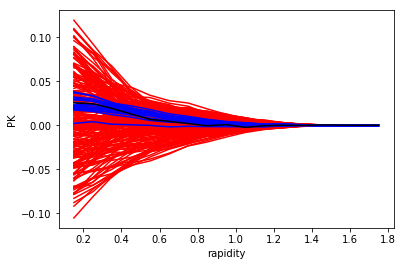

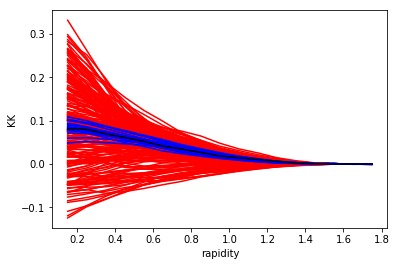

In [60]:


ntrace = np.zeros((20,12))
for i in range(20):
    ntrace[i] = mcmc.trace[int(mcmc.trace.shape[0]/20*i),:]
print(ntrace)
tracey_buffed = mcmc.MLA.predict(ntrace)
tracey = tracey_buffed/scale
print("Red==200 Model Runs\nBlue==20 posterior from NN MCMC\nBlack==EXP BF")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,tracey[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,tracey[:,17:34].T,'blue')
plt.plot(dy,exp[25:42].T,'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,tracey[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,tracey[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")

x, posterior = RestFeatures(X_train_norm,ntrace,maxv,minv)

import numpy 
numpy.savetxt('NNposterior.dat',posterior , delimiter = ' ')  




# THE EXTRAS

Nodes in NN layer 100
NN performance 0.9718799232931142
Red==190 Model Runs
Blue==10 Model Runs
Black==NN attempt to create BLUE from RED


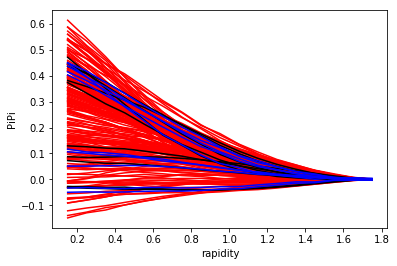

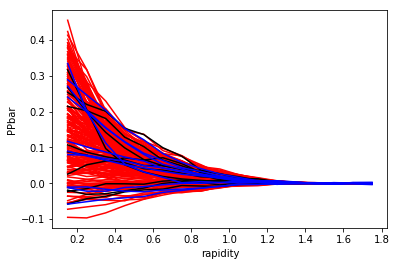

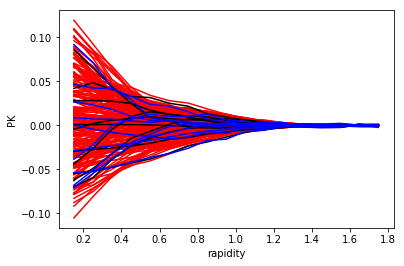

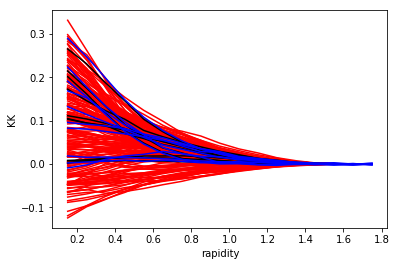

Black==Experimental BF
Blue==NN attempt to create ExpBF from mcmctrace mean parameters


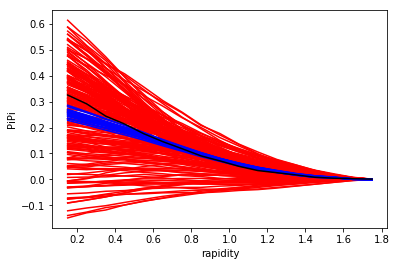

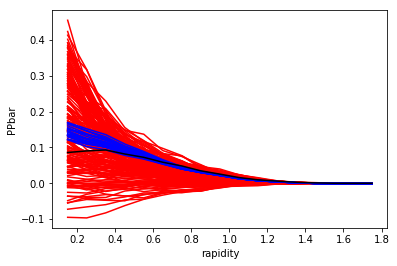

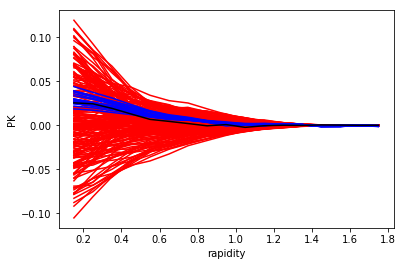

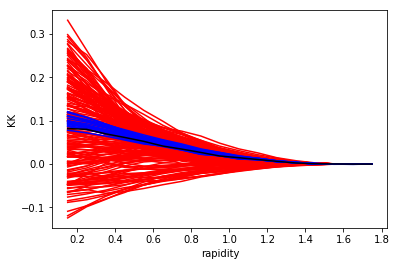

[[-6.28594553e-02 -5.98762298e-01  1.12550559e-01 ... -1.17707517e-01
  -6.54495385e-02 -2.48068771e-02]
 [ 5.94434222e-02 -2.70306885e-01 -2.46609965e-02 ...  1.78385654e-01
  -1.04838218e-01  1.07201809e-01]
 [ 2.24830834e-04  3.55201411e-01 -1.78639502e-01 ... -2.19482899e-01
  -8.85155071e-02  1.22074183e-01]
 ...
 [-5.86577431e-02  2.51137041e-02  1.14797096e-01 ... -1.98599129e-01
   8.45662843e-02 -3.37332110e-03]
 [-5.13779950e-02  2.51455563e-02 -8.21708822e-03 ...  1.32933195e-01
  -1.89407801e-01 -2.32124886e-02]
 [-3.22780573e-02 -1.89760505e-02 -1.52870217e-02 ...  8.00071937e-02
   9.34321657e-02 -1.47424914e-01]]


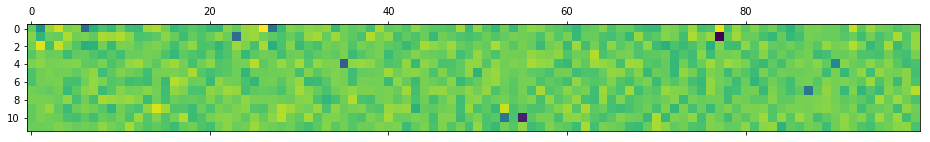

In [107]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
X_train = parameters[:190,:]
y_train = model[:190,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

xscale=1.0
yscale=1.0
#X_train_norm, X_test_norm = normalize_features(X_train,X_test)
X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)
#y_train_norm, y_test_norm, ymaxv, yminv = NormFeatures(y_train,y_test,yscale)

layer=100
print("Nodes in NN layer",layer)
NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )


NN.fit(X_train_norm,y_train)
y_pred = NN.predict(X_test_norm)
perf = NN.score(X_test_norm,y_test)
#y_, y_pred = RestFeatures(y_train_norm,y_pred_norm, ymaxv, yminv,yscale)

print("NN performance",perf)

print("Red==190 Model Runs\nBlue==10 Model Runs\nBlack==NN attempt to create BLUE from RED")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,y_test[:,:17].T,'black')
plt.plot(dy,y_pred[:,:17].T,'blue')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,y_test[:,17:34].T,'black')
plt.plot(dy,y_pred[:,17:34].T,'blue')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,y_test[:,34:51].T,'black')
plt.plot(dy,y_pred[:,34:51].T,'blue')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,y_test[:,51:68].T,'black')
plt.plot(dy,y_pred[:,51:68].T,'blue')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")



mcmc_posterior = LoadData(folder+"/exp_posterior.dat")

xtn, mcmcnorm, xmaxv, xminv = NormFeatures(X_train,mcmc_posterior,xscale)
ymcmc = NN.predict(mcmcnorm)
#y_, ymcmc = RestFeatures(y_train_norm,ymcmc_norm,ymaxv,yminv,yscale)

print("Black==Experimental BF\nBlue==NN attempt to create ExpBF from mcmctrace mean parameters")

fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,ymcmc[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,ymcmc[:,17:34].T,'blue')
plt.plot(dy,exp[25:42],'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,ymcmc[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,ymcmc[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn_exp.pdf")

plt.matshow(NN.coefs_[0])
print(NN.coefs_[0])

#write matrix to file 
import numpy 
numpy.savetxt('matrix.txt', NN.coefs_[0], delimiter = ' ')  

#read file into a matrix
#import numpy  
#my_matrix = numpy.loadtxt(open("matrix.txt","rb"),delimiter=",",skiprows=0)

Nodes in NN layer 100
NN performance 0.9708291662223046
Red==190 Model Runs
Blue==10 Model Runs
Black==NN attempt to create BLUE from RED


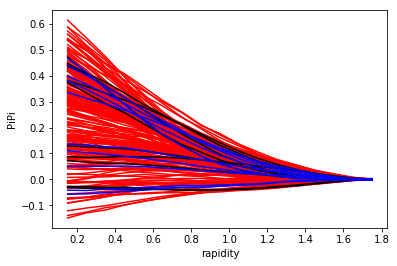

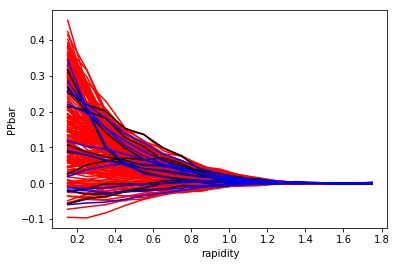

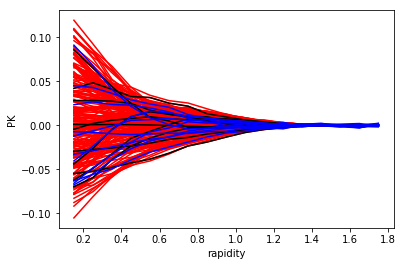

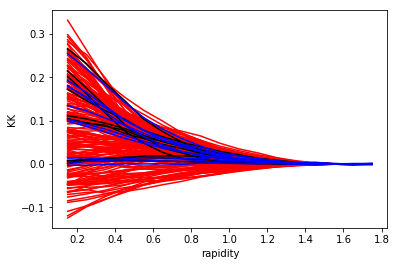

Black==Experimental BF
Blue==NN attempt to create ExpBF from mcmctrace mean parameters


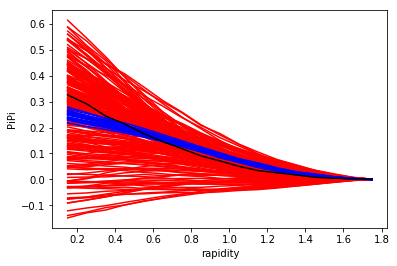

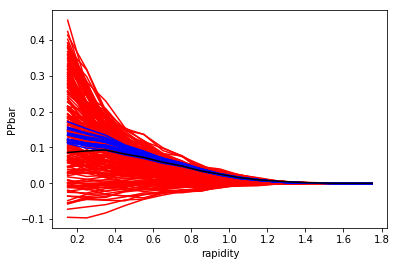

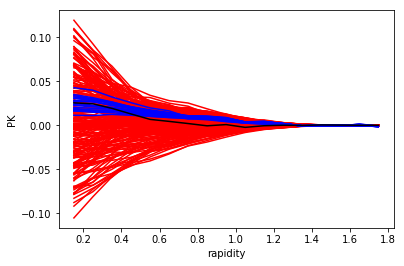

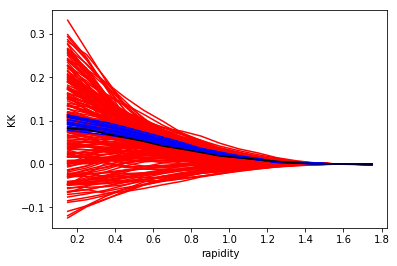

[[-0.14664056  0.10658466 -0.05311658 ...  0.01503261  0.03665313
   0.18661792]
 [ 0.19683011  0.19553457 -0.19984303 ... -0.0592901   0.00177383
  -0.00160431]
 [ 0.08088462  0.06705338 -0.01913568 ... -0.01032244  0.09191147
  -0.07453383]
 ...
 [-0.22603172  0.0644095  -0.0984937  ... -0.27501806 -0.15258495
  -0.19587069]
 [ 0.0335639   0.21331503 -0.19458139 ... -0.1620348  -0.09050687
   0.17313405]
 [-0.238347   -0.19748712 -0.02484571 ...  0.02803712 -0.16365725
   0.12429374]]


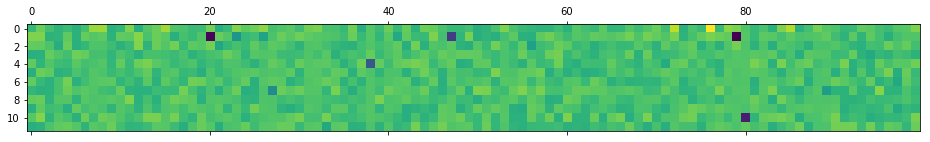

In [10]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
X_train = parameters[:200,:]
y_train = model[:200,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

#X_train_norm, X_test_norm = normalize_features(X_train,X_test)
X_train_norm, X_test_norm, maxv, minv = NormFeatures(X_train,X_test)

layer=100
print("Nodes in NN layer",layer)
NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )


NN.fit(X_train_norm,y_train)
y_pred = NN.predict(X_test_norm)
perf = NN.score(X_test_norm,y_test)

print("NN performance",perf)

print("Red==190 Model Runs\nBlue==10 Model Runs\nBlack==NN attempt to create BLUE from RED")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,y_test[:,:17].T,'black')
plt.plot(dy,y_pred[:,:17].T,'blue')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,y_test[:,17:34].T,'black')
plt.plot(dy,y_pred[:,17:34].T,'blue')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,y_test[:,34:51].T,'black')
plt.plot(dy,y_pred[:,34:51].T,'blue')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,y_test[:,51:68].T,'black')
plt.plot(dy,y_pred[:,51:68].T,'blue')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")

mcmcmean = LoadData(folder+"/exp_posterior.dat")

xtn, mcmcnorm, maxv, minv = NormFeatures(X_train,mcmcmean)
ymcmc = NN.predict(mcmcnorm)


print("Black==Experimental BF\nBlue==NN attempt to create ExpBF from mcmctrace mean parameters")

fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,0:17].T,'red')
plt.plot(dy,ymcmc[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,ymcmc[:,17:34].T,'blue')
plt.plot(dy,exp[25:42],'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,ymcmc[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,ymcmc[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn_exp.pdf")

plt.matshow(NN.coefs_[0])
print(NN.coefs_[0])

#write matrix to file 
import numpy 
numpy.savetxt('matrix.txt', NN.coefs_[0], delimiter = ' ')  

#read file into a matrix
#import numpy  
#my_matrix = numpy.loadtxt(open("matrix.txt","rb"),delimiter=",",skiprows=0)

50
0.9252495923496004


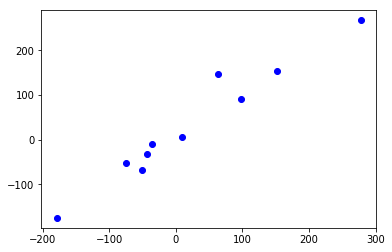

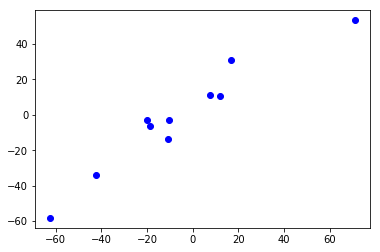

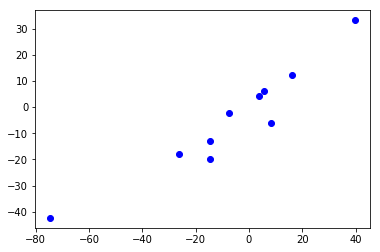

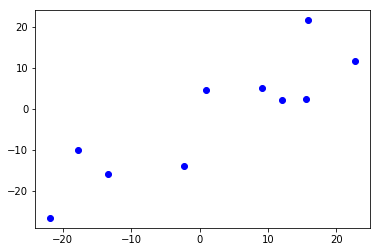

75
0.9750987756286803


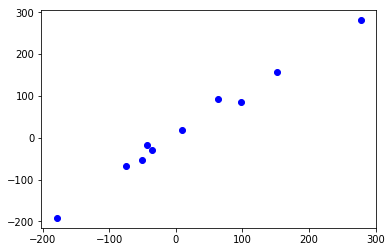

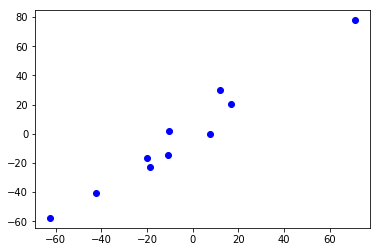

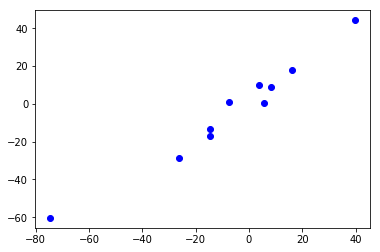

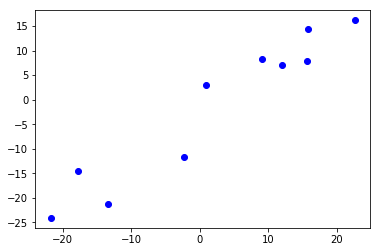

100
0.9492900206544125


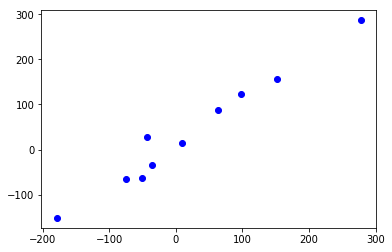

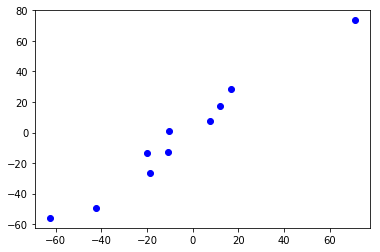

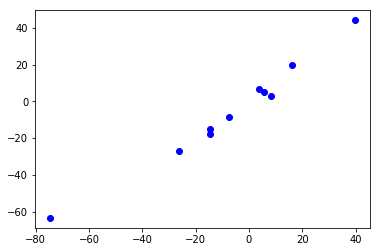

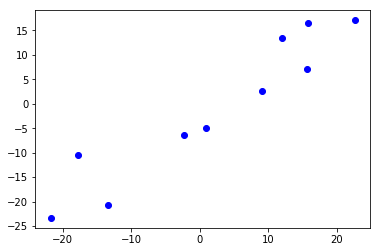

150
0.9402450654780266


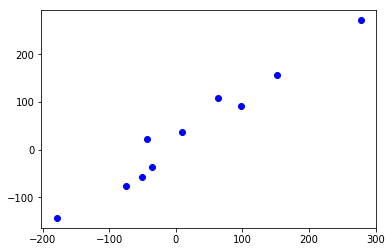

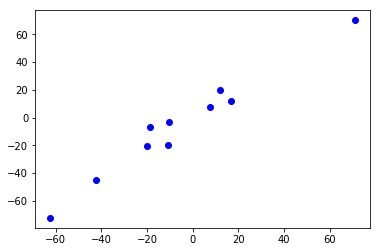

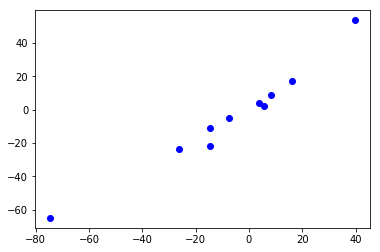

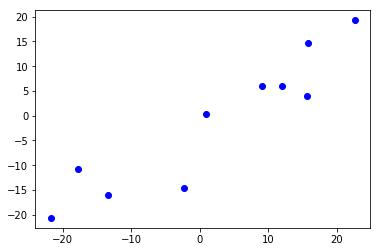

1000
0.9336684629233238


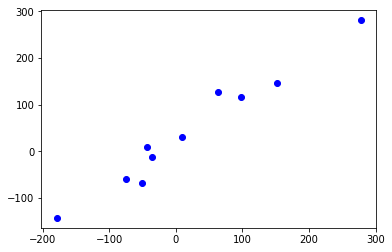

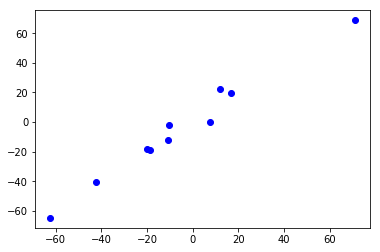

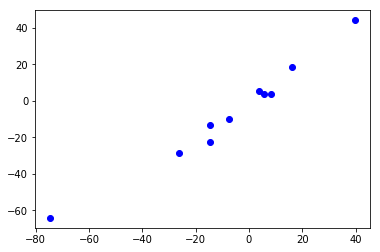

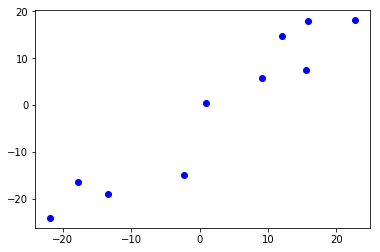

In [190]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X_train = parameters[:190,:]
y_train = pca[:190,:]
X_test = parameters[190:,:]
y_test = pca[190:,:]

#X_train_norm, X_test_norm = normalize_features(X_train,X_test)
X_train_norm, X_test_norm, maxv, minv = NormFeatures(X_train,X_test)
for layer in (50,75,100,150,1000):
    print(layer)
    NN = MLPRegressor(hidden_layer_sizes=(layer), \
                      max_iter=500,
                      solver='lbfgs', \
                      alpha=1e-4, \
                      activation='relu', \
                      learning_rate_init=1e-3, \
                      #random_sate=1, \
                     )

    NN.fit(X_train_norm,y_train)
    y_pred = NN.predict(X_test_norm)
    perf = NN.score(X_test_norm,y_test)
    print(perf)
    plt.plot(y_test[:,0],y_pred[:,0],'bo')
    plt.show()
    plt.plot(y_test[:,1],y_pred[:,1],'bo')
    plt.show()
    plt.plot(y_test[:,2],y_pred[:,2],'bo')
    plt.show()
    plt.plot(y_test[:,3],y_pred[:,3],'bo')
    plt.show()

50
0.8604627925495224


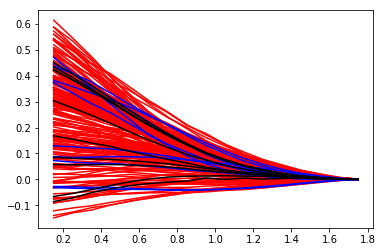

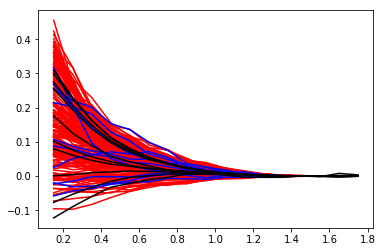

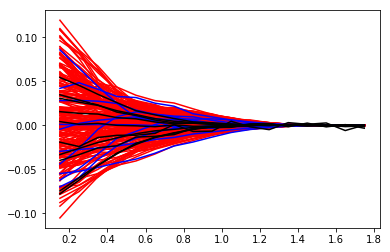

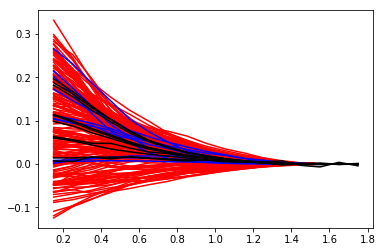

70
0.9555119888312751


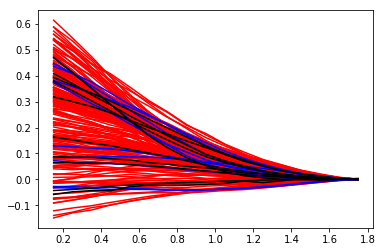

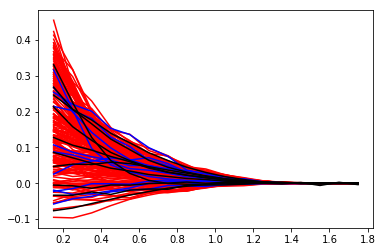

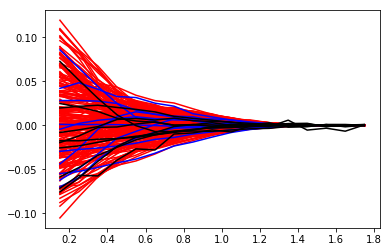

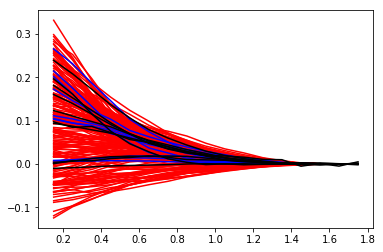

75
0.9791056339824443


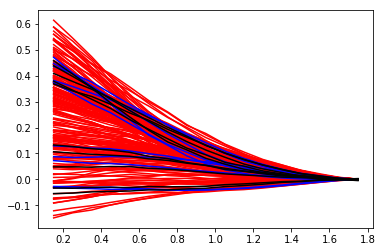

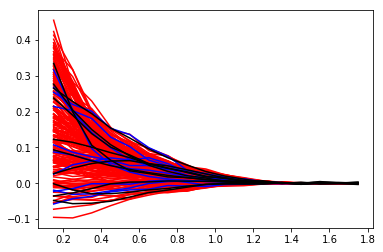

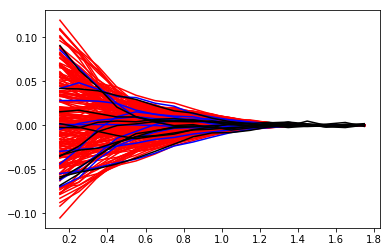

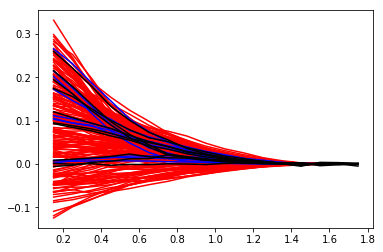

85
0.9556116994353985


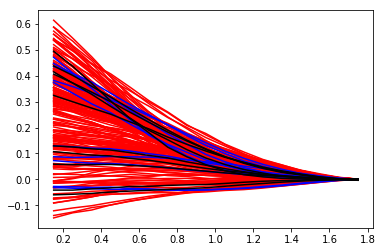

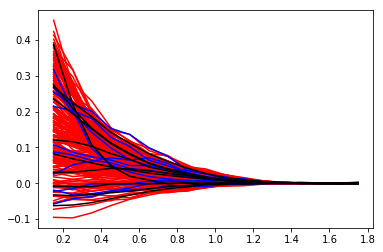

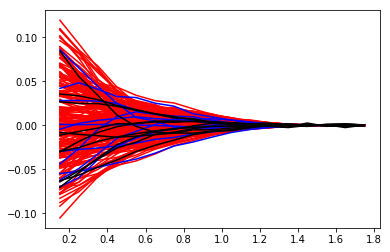

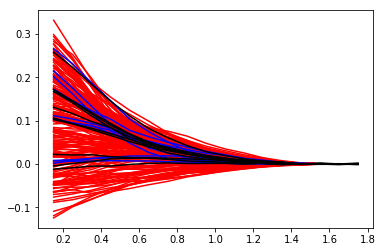

100
0.9812675478232985


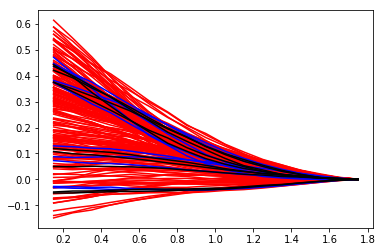

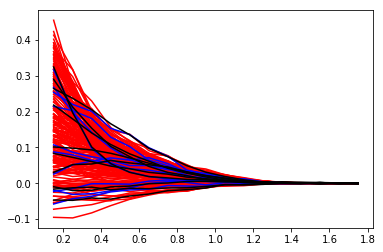

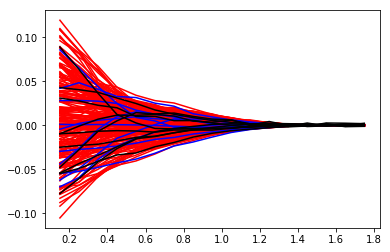

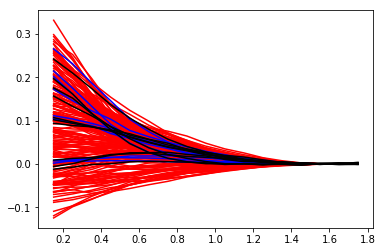

In [191]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
X_train = parameters[:190,:]
y_train = model[:190,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

#X_train_norm, X_test_norm = normalize_features(X_train,X_test)
X_train_norm, X_test_norm,maxv,minv = NormFeatures(X_train,X_test)


for layer in (50,70,75,85,100):
    print(layer)
    NN = MLPRegressor(hidden_layer_sizes=(layer), \
                      max_iter=500,
                      solver='lbfgs', \
                      alpha=1e-4, \
                      learning_rate_init=1e-3, \
                      activation='relu', \
                      
                      #random_sate=1, \
                     )


    NN.fit(X_train_norm,y_train)
    y_pred = NN.predict(X_test_norm)
    perf = NN.score(X_test_norm,y_test)
    print(perf)
    plt.plot(dy,y_train[:,:17].T,'red',dy,y_test[:,:17].T,'blue')
    plt.plot(dy,y_pred[:,:17].T,'black')
    plt.show()
    plt.plot(dy,y_train[:,17:34].T,'red',dy,y_test[:,17:34].T,'blue')
    plt.plot(dy,y_pred[:,17:34].T,'black')
    plt.show()
    plt.plot(dy,y_train[:,34:51].T,'red',dy,y_test[:,34:51].T,'blue')
    plt.plot(dy,y_pred[:,34:51].T,'black')
    plt.show()
    plt.plot(dy,y_train[:,51:68].T,'red',dy,y_test[:,51:68].T,'blue')
    plt.plot(dy,y_pred[:,51:68].T,'black')
    plt.show()

In [145]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
X_train = model[:190,:]
y_train = parameters[:190,:]

X_test = model[190:,:]
y_test = parameters[190:,:]

X_train_norm, X_test_norm = normalize_features(X_train,X_test)
layers=[75,100,200,500]
matrix = np.zeros((len(layers),len(layers),len(layers)))
i1=0
for layer1 in layers:
    i2=0
    for layer2 in layers:
        i3=0
        for layer3 in layers:
            print(layer1,layer2,layer3)
            NN = MLPRegressor(hidden_layer_sizes=(layer1,layer2,layer3), \
                              max_iter=500,
                              solver='adam', \
                              alpha=5*1e-4, \
                              learning_rate_init=5*1e-3, \
                              activation='relu', \
                              #random_sate=1, \
                             )


            NN.fit(X_train_norm,y_train)
            y_pred = NN.predict(X_test_norm)
            perf = NN.score(X_test_norm,y_test)
            print(perf)
            matrix[i1,i2,i3]=perf
            '''
            fig, ax = plt.subplots()
            ax.set_xlim(0,2)
            ax.set_ylim(0,2)
            ax.grid(b=True, which='major', color='k', linestyle='--')
            plt.plot(y_test[:,0],y_pred[:,0],'bo')
            plt.plot(y_test[:,3],y_pred[:,3],'co')
            plt.plot(y_test[:,6],y_pred[:,6],'ro')
            plt.plot(y_test[:,9],y_pred[:,9],'mo')
            plt.show()

            fig, ax = plt.subplots()
            ax.set_xlim(-1,1)
            ax.set_ylim(-1,1)
            ax.grid(b=True, which='major', color='k', linestyle='--')
            plt.plot(y_test[:,2],y_pred[:,2],'bo')
            plt.plot(y_test[:,5],y_pred[:,5],'co')
            plt.plot(y_test[:,8],y_pred[:,8],'ro')
            plt.plot(y_test[:,11],y_pred[:,11],'mo')
            plt.show()
            '''
            i3+=1
        i2+=1
    i1+=1
print(matrix)

75 75 75
0.43755022026912455
75 75 100
0.46400906191144575
75 75 200
0.42780760914399374
75 75 500
0.4447453031820138
75 100 75
0.390427658419229
75 100 100
0.3097030555278446
75 100 200
0.4300053151247563
75 100 500
0.49538419217692503
75 200 75
0.2984218267650534
75 200 100
0.47139445042728206
75 200 200
0.3821042348477061
75 200 500
0.477606301682143
75 500 75
0.4700897611238122
75 500 100
0.2548668853685611
75 500 200
0.36267362193122
75 500 500
0.43253989154921235
100 75 75
0.35925710532477584
100 75 100
0.343958890486899
100 75 200
0.33220747937714706
100 75 500
0.5010145525583586
100 100 75
0.4479352418204392
100 100 100
0.3769913250037717
100 100 200
0.45588499211362393
100 100 500
0.40824532257056334
100 200 75
0.35552589787794703
100 200 100
0.4506225878484641
100 200 200
0.3287043255077441
100 200 500
0.5180781852760974
100 500 75
0.41495248048245953
100 500 100
0.4205340053270284
100 500 200
0.36231261556940825
100 500 500
0.3344019933402606
200 75 75
0.4749183057559619
200

Nodes in NN layer 100
NN performance 0.9740028954214954
Red==190 Model Runs
Blue==10 Model Runs
Black==NN attempt to create BLUE from RED


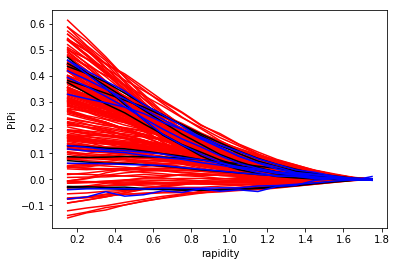

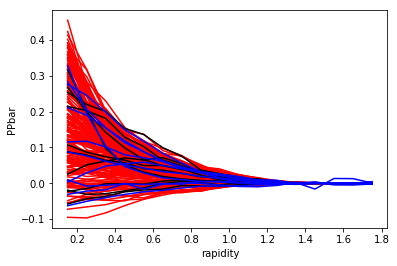

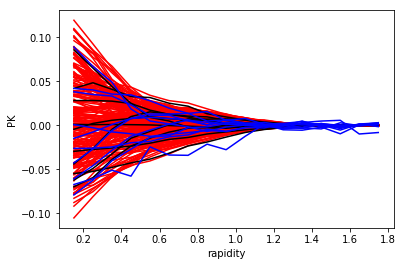

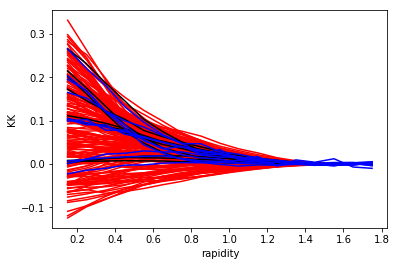

Black==Experimental BF
Blue==NN attempt to create ExpBF from mcmctrace mean parameters


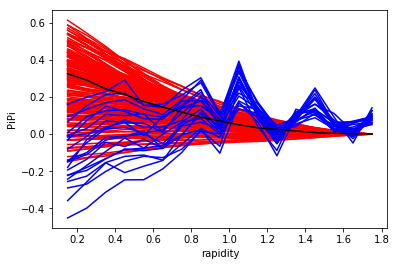

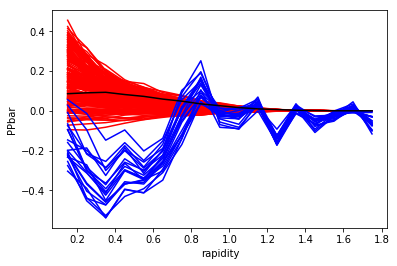

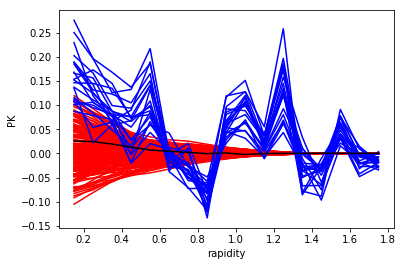

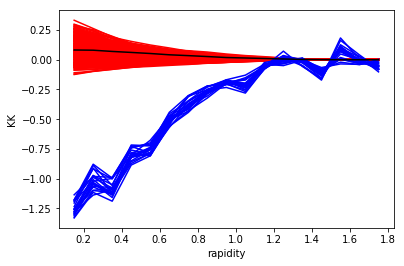

[[ 0.0685567   0.19811015  0.17160122 ...  0.08505718 -0.24716865
  -0.00610688]
 [ 0.08604807 -0.61478452  0.03212942 ...  0.04388056 -0.22719068
  -0.01011143]
 [ 0.1535194   0.02559045  0.00557575 ... -0.00181001 -0.29040576
  -0.00993484]
 ...
 [-0.1657378   0.01765743  0.0357424  ... -0.01916151 -0.0053527
  -0.25372861]
 [-0.04584066 -0.01035647  0.00225417 ...  0.01741185  0.02818694
  -0.01209027]
 [ 0.09656757 -0.00895145 -0.03824548 ... -0.02838781 -0.01522665
   0.125946  ]]


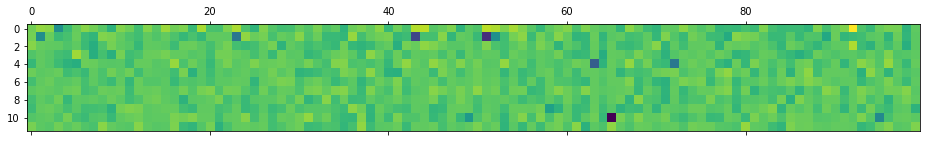

In [193]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   
X_train = parameters[:190,:]
y_train = model[:190,:]

X_test = parameters[190:,:]
y_test = model[190:,:]

#X_train_norm, X_test_norm = normalize_features(X_train,X_test)
X_train_norm, X_test_norm, maxv, minv = NormFeatures(X_train,X_test)
layer=100
print("Nodes in NN layer",layer)
NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \

                  #random_sate=1, \
                 )


NN.fit(X_train_norm,y_train)
y_pred = NN.predict(X_test_norm)
perf = NN.score(X_test_norm,y_test)
print("NN performance",perf)

print("Red==190 Model Runs\nBlue==10 Model Runs\nBlack==NN attempt to create BLUE from RED")
figfolder = "figs"
fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,:17].T,'red')
plt.plot(dy,y_test[:,:17].T,'black')
plt.plot(dy,y_pred[:,:17].T,'blue')
plt.show()
fig.savefig(figfolder+"/pipi_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,y_test[:,17:34].T,'black')
plt.plot(dy,y_pred[:,17:34].T,'blue')
plt.show()
fig.savefig(figfolder+"/ppbar_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,y_test[:,34:51].T,'black')
plt.plot(dy,y_pred[:,34:51].T,'blue')
plt.show()
fig.savefig(figfolder+"/pk_nn.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,y_test[:,51:68].T,'black')
plt.plot(dy,y_pred[:,51:68].T,'blue')
plt.show()
fig.savefig(figfolder+"/kk_nn.pdf")

mcmcmean = LoadData(folder+"/exp_posterior.dat")
xtn, mcmcnorm = normalize_features(X_train,mcmcmean)
ymcmc = NN.predict(mcmcnorm)


print("Black==Experimental BF\nBlue==NN attempt to create ExpBF from mcmctrace mean parameters")

fig, ax = plt.subplots()
plt.ylabel('PiPi')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,0:17].T,'red')
plt.plot(dy,ymcmc[:,:17].T,'blue')
plt.plot(dy,exp[:17].T,'black')
plt.show()
fig.savefig(figfolder+"/pipi_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PPbar')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,17:34].T,'red')
plt.plot(dy,ymcmc[:,17:34].T,'blue')
plt.plot(dy,exp[25:42],'black')
plt.show()
fig.savefig(figfolder+"/ppbar_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('PK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,34:51].T,'red')
plt.plot(dy,ymcmc[:,34:51].T,'blue')
plt.plot(dy,exp[50:67].T,'black')
plt.show()
fig.savefig(figfolder+"/pk_nn_exp.pdf")

fig, ax = plt.subplots()
plt.ylabel('KK')
plt.xlabel('rapidity')
plt.plot(dy,y_train[:,51:68].T,'red')
plt.plot(dy,ymcmc[:,51:68].T,'blue')
plt.plot(dy,exp[75:92].T,'black')
plt.show()
fig.savefig(figfolder+"/kk_nn_exp.pdf")

plt.matshow(NN.coefs_[0])
print(NN.coefs_[0])
